In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd


In [4]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url='train-clean-100', download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url='test-clean', download=True)

In [5]:
test_dataset[2]

(tensor([[ 0.0004,  0.0006,  0.0008,  ..., -0.0001, -0.0004, -0.0007]]),
 16000,
 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS',
 1089,
 134686,
 2)

In [6]:
test_dataset[3][0].shape

torch.Size([1, 42880])

In [7]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data)/sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


In [8]:
audio_np = audio_data.numpy()
y_4k = librosa.resample(audio_np, sr, 4000)

print(len(audio_np), len(y_4k))
ipd.Audio(y_4k, rate=4000)

C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass orig_sr=16000, target_sr=4000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


52400 13100


In [9]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [10]:
bit = 8
max_value = 2**(bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

In [11]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x))/ np.log(1+mu)

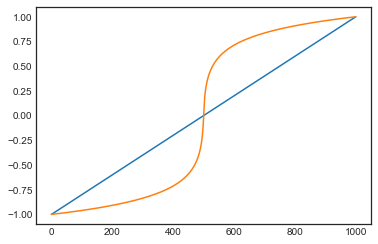

In [12]:
x = np.linspace(-1,1,1000)
x_mu = mu_law(x)

plt.figure(figsize=[6,4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [13]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

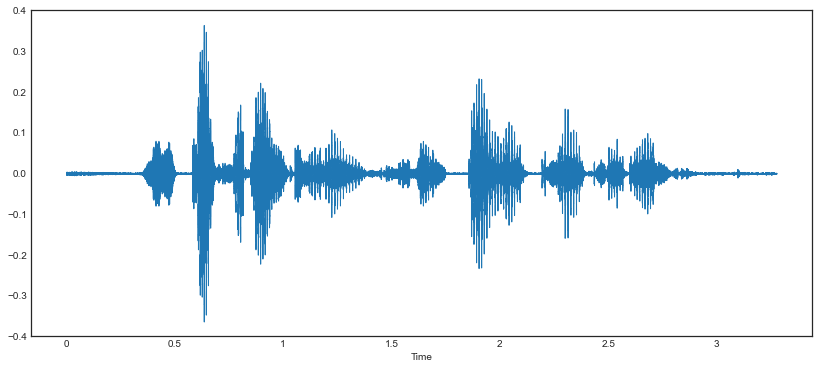

In [14]:
audio_np = audio_data.numpy()

fig = plt.figure(figsize=(14, 6))
librosa.display.waveshow(audio_np[0:100000], sr=sr); #waveplot -> waveshow

In [15]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [16]:
A = 0.9
f = 340
phi = np.pi/2
fs = 22050
t = 1

In [17]:
sin = Sinusoid(A, f, phi,fs,t)

In [18]:
A = 0.9
f = 260
phi = np.pi/2
fs = 22050
t = 1

In [19]:
sin2 = Sinusoid(A,f,phi,fs,t)

In [20]:
complexwav = sin + sin2

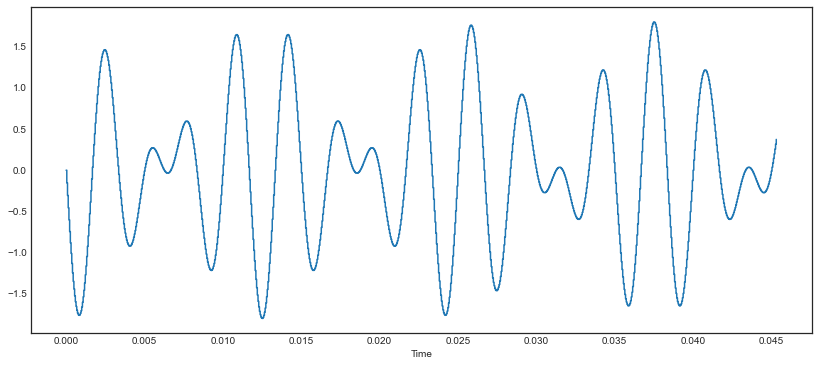

In [21]:
fig = plt.figure(figsize=(14,6))
librosa.display.waveshow(complexwav[0:1000], sr=fs);

In [22]:
ipd.Audio(sin + sin/2 + sin/4, rate=fs)

In [23]:
ipd.Audio(sin2 + sin2/2 + sin2/4, rate=fs)

In [24]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, fs=22050, amplitude_max=0.5):
    N= int(duration * fs)
    t = np.arange(N) / fs
    x = []
    for p in pitches:
        omega = 2 ** ((p-69)/12) *440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x

In [25]:
duration = 1
fs = 22050
pitches = [36, 48, 60, 72, 84, 96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, fs=fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}')
ipd.display(ipd.Audio(data=x, rate=fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


In [26]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arage(N)
    
    for k in range(N):
        s = np.exp(1j * 2*np.pi *k/N*nv)
        X = np.append(X, sum(x*np.conjugate(s)))
    return X

In [27]:
print(audio_np.shape, sr)

(52400,) 16000


In [28]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
print(S.shape, len(S[0]), S[0][0])

(513, 103) 103 (0.022626022+0j)


In [29]:
D = np.abs(S)**2
print(D.shape)

(513, 103)


C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\librosa\util\decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


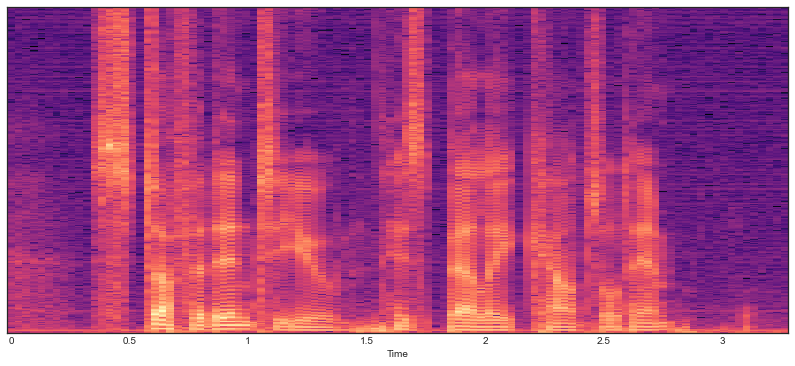

In [30]:
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14,6))
librosa.display.specshow(log_S, sr=16000, x_axis='time')

In [44]:
def frame_audio(audio, fft_size=1024, hop_size=20, sample_rate=22050):
    audio = np.pad(audio, int(fft_size/2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size/1000).astype(int)
    frame_num = int((len(audio)-fft_size)/frame_len) + 1
    frames = np.zeros((frame_num, fft_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len + fft_size]
        
    return frames

audio_framed = frame_audio(audio_np)
print('Framed audio shape: {}'.format(audio_framed.shape))

Framed audio shape: (119, 1024)


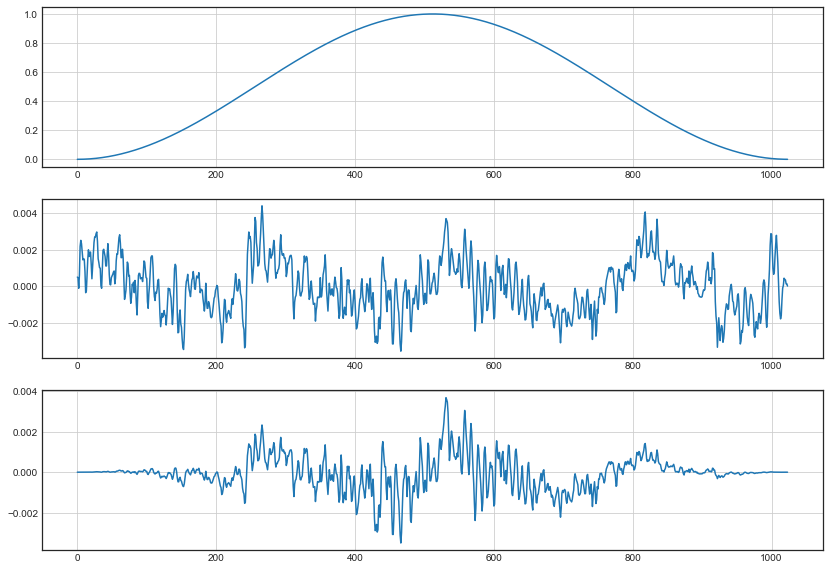

In [46]:
from scipy import signal

window = signal.get_window('hann', 1024,fftbins=True)
audio_win = audio_framed * window
idx = 3

plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(window)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(audio_framed[idx])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(audio_win[idx])
plt.grid(True)
plt.show()

In [51]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S)**2

In [52]:
mel_basis = librosa.filters.mel(sr, n_fft=1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
print(mel_S.shape)

(40, 103)


C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.0010376   0.00109863  0.00091553 ... -0.0007019  -0.00097656
 -0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


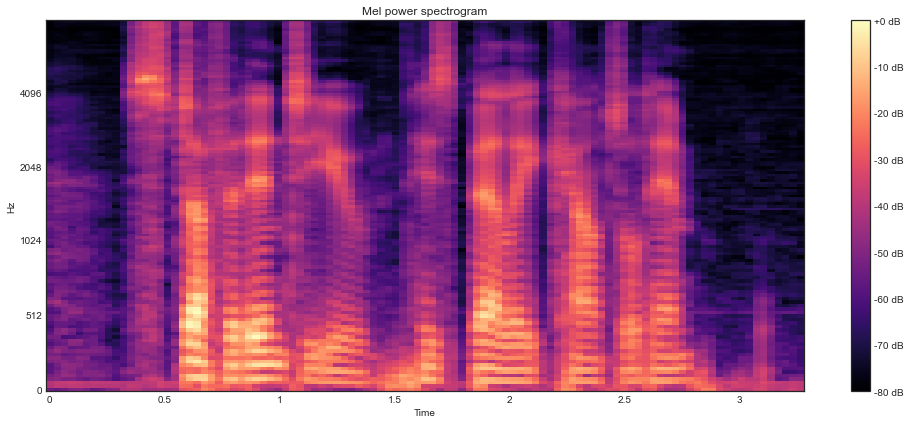

In [55]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [56]:
log_mel_S = librosa.power_to_db(mel_S)
print(log_mel_S.shape)

(40, 103)


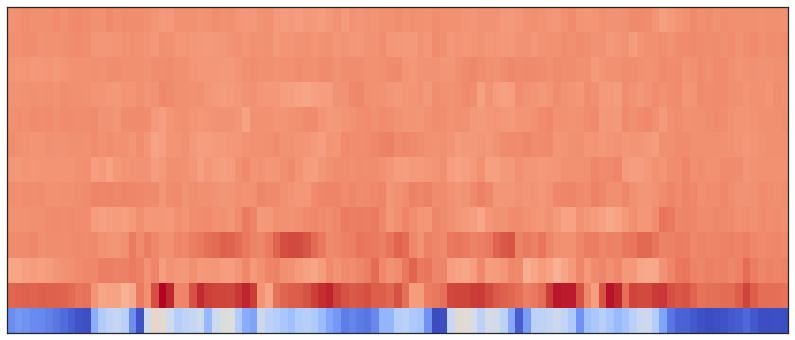

In [57]:
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)
plt.figure(figsize=(14,6))
librosa.display.specshow(mfcc);

(13, 103)


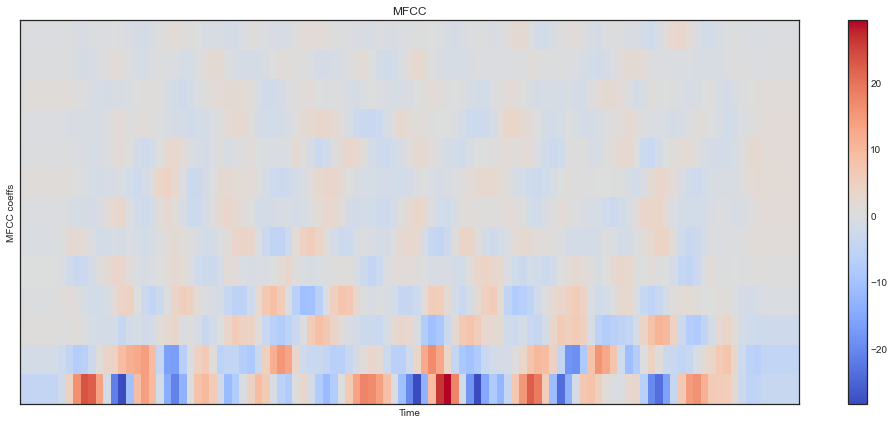

In [58]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(14,6))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [59]:
spectral_centroids = librosa.feature.spectral_centroid(audio_np, sr=sr)[0]
print(spectral_centroids.shape)

(103,)


C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.0010376   0.00109863  0.00091553 ... -0.0007019  -0.00097656
 -0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


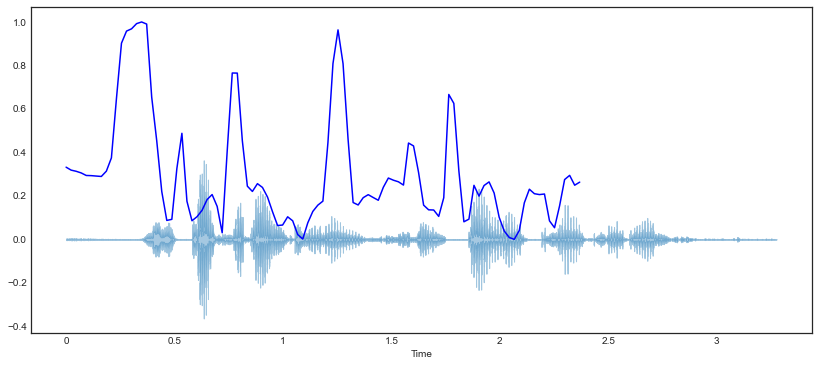

In [60]:
from sklearn.preprocessing import minmax_scale

plt.figure(figsize=(14,6))
frames= range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

librosa.display.waveshow(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='b')

C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[0.0110376  0.01109863 0.01091553 ... 0.0092981  0.00902344 0.00890137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


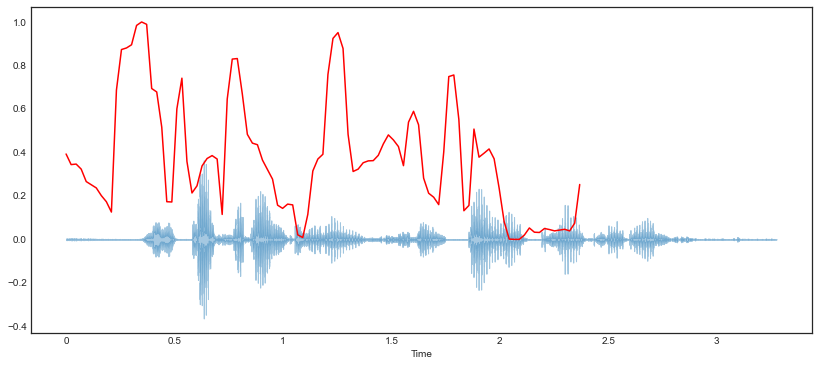

In [63]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio_np+0.01, sr=sr)[0]
plt.figure(figsize=(14,6))

librosa.display.waveshow(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color='r')

C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[0.0110376  0.01109863 0.01091553 ... 0.0092981  0.00902344 0.00890137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.0110376  0.01109863 0.01091553 ... 0.0092981  0.00902344 0.00890137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass y=[0.0110376  0.01109863 0.01091553 ... 0.0092981  0.00902344 0.00890137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


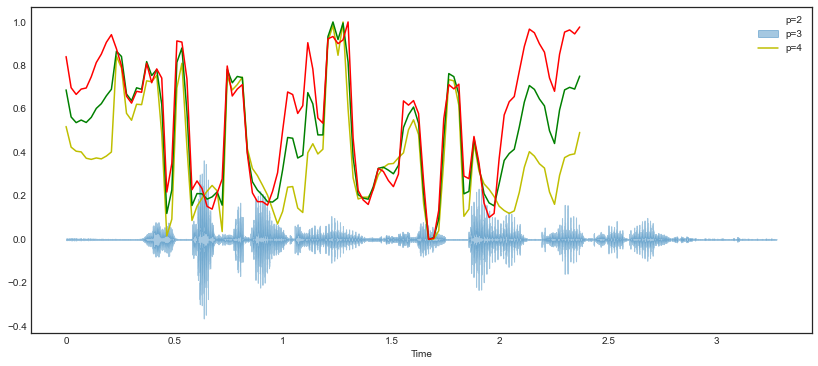

In [66]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio_np+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(14,6))

librosa.display.waveshow(audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2, axis=0), color='y')
plt.plot(t, minmax_scale(spectral_bandwidth_3, axis=0), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4, axis=0), color='r')
plt.legend(('p=2', 'p=3', 'p=4'))

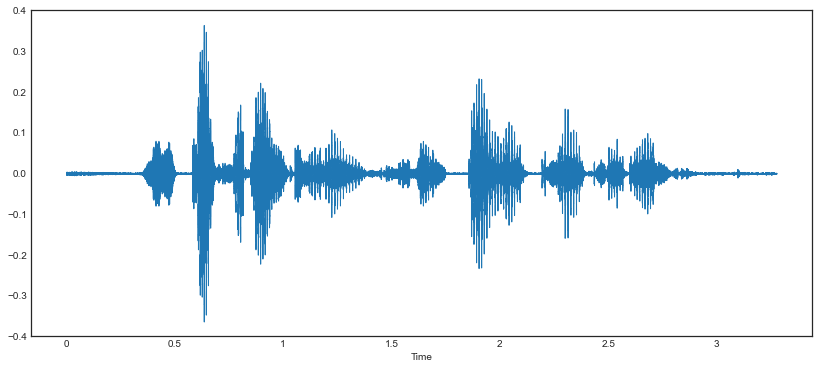

In [67]:
plt.figure(figsize=(14,6))
librosa.display.waveshow(audio_np, sr=sr)

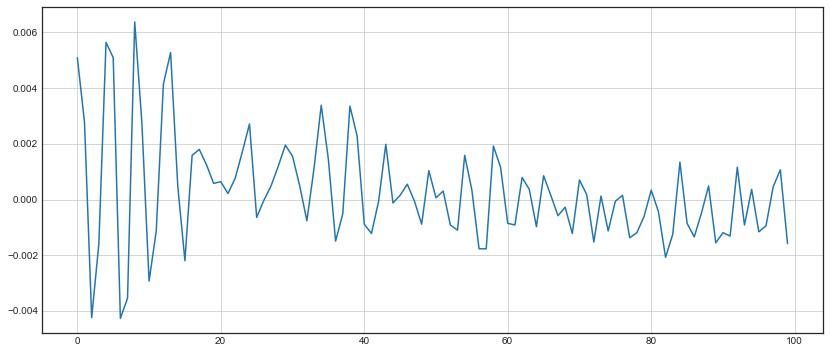

In [69]:
n0 = 8000
n1 = 8100
plt.figure(figsize=(14,6))
plt.plot(audio_np[n0:n1])
plt.grid()

In [73]:
zero_crossings = librosa.zero_crossings(audio_np[n0:n1], pad=False)
print(zero_crossings.shape)
print(sum(zero_crossings))

zcrs = librosa.feature.zero_crossing_rate(audio_np)
print(zcrs.shape)

(100,)
47
(1, 103)


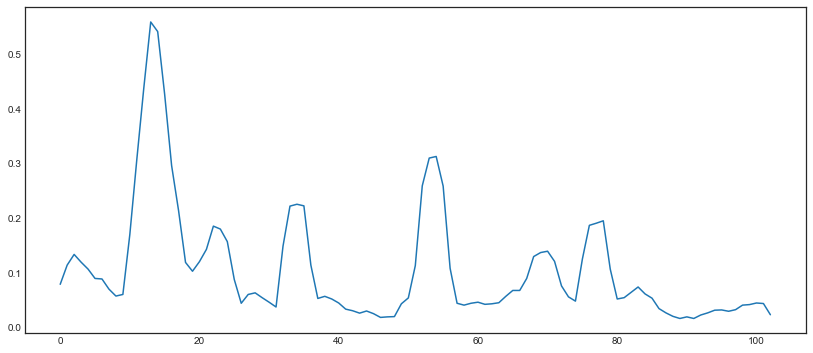

In [74]:
plt.figure(figsize=(14,6))
plt.plot(zcrs[0])

(20, 103)


C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.0010376   0.00109863  0.00091553 ... -0.0007019  -0.00097656
 -0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


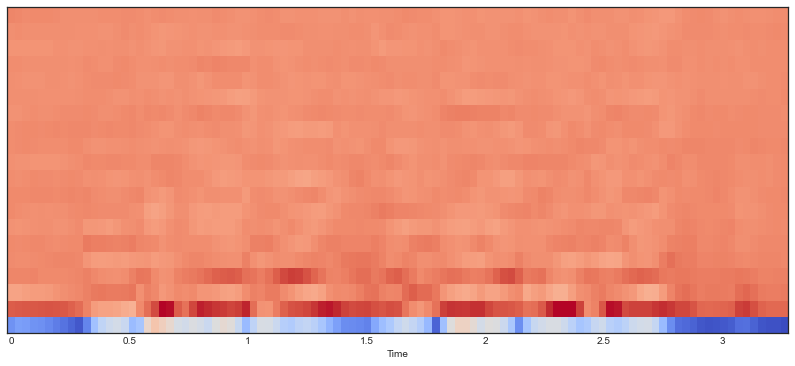

In [75]:
mfccs = librosa.feature.mfcc(audio_np, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(14,6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

C:\ProgramData\Anaconda3\envs\pytp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.0010376   0.00109863  0.00091553 ... -0.0007019  -0.00097656
 -0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


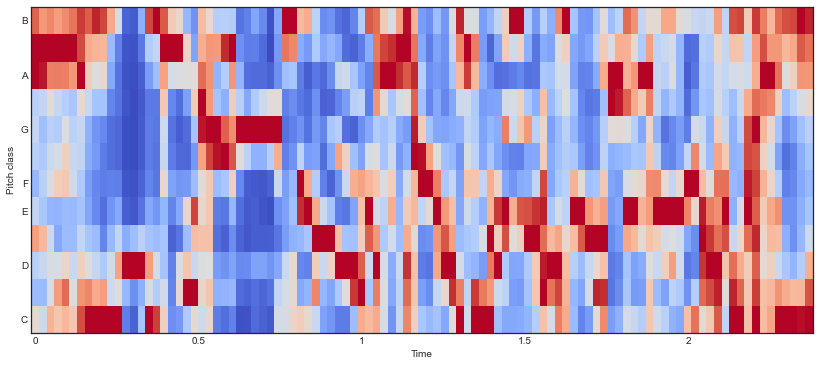

In [76]:
chromagram = librosa.feature.chroma_stft(audio_np, sr=sr, hop_length=512)
plt.figure(figsize=(14,6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

In [78]:
from scipy.signal import butter, lfilter, freqz

def butter_pass(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff/ nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b ,a

def butter_filter(data,cutoff, fs, btype, order=5):
    b,a = butter_pass(cutoff, fs,btype, order=order)
    y= lfilter(b,a,data)
    return y

In [79]:
order = 6
fs = 16000
cutoff= 2048

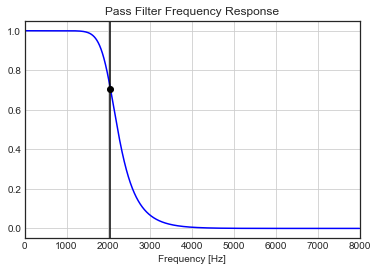

In [80]:
b,a =butter_pass(cutoff,fs,'lowpass', order)

w,h = freqz(b,a,worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title('Pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.grid()

In [82]:
T = len(audio_np)/ sr
n = int(T*sr)
t = np.linspace(0,T,n,endpoint=False)

y = butter_filter(audio_np, cutoff, fs,'lowpass', order)
ipd.Audio(y, rate=fs)

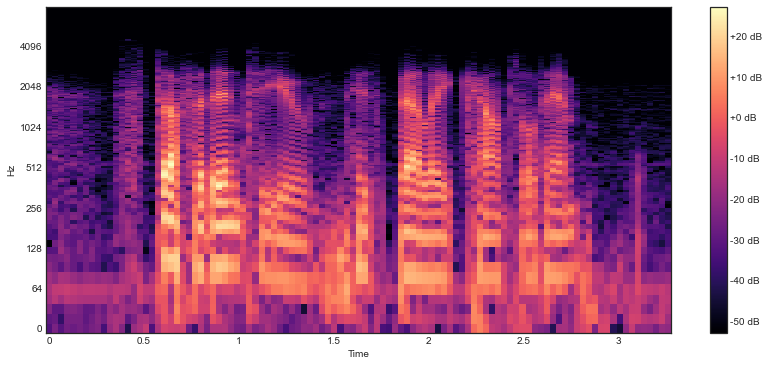

In [83]:
X = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)
S = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,6))
librosa.display.specshow(S, sr=fs, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')